# Producing a final year project allocation


In this tutorial we will be solving an instance of SA using raw, tabular data. This tutorial will cover all aspects of this process: from getting the data into a form that Matching can handle, all the way through to analysing the results through data visualisation.

In [1]:
import numpy as np
import pandas as pd

The data for this tutorial has been archived [here](https://doi.org/10.5281/zenodo.3514287), and the source code used to generate it is available [on GitHub](https://github.com/daffidwilde/matching/blob/master/docs/tutorials/project_allocation/data.py).

In [2]:
raw_students = pd.read_csv("https://zenodo.org/record/3514287/files/students.csv")
raw_projects = pd.read_csv("https://zenodo.org/record/3514287/files/projects.csv")
raw_supervisors = pd.read_csv("https://zenodo.org/record/3514287/files/supervisors.csv")

---
## Cleaning the data

In order to use Matching's implementation of SA, we require the data to be "clean". This process will require us to inspect the data and remove any erroneous rows from each of our datasets.

### Students

We begin with the students. The first thing we have to do is find out how many choices students were allowed to make:

In [3]:
raw_students.columns

Index(['name', 'rank', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24'],
      dtype='object')

We can see that students could make up to 25 selections, and the choice columns are numbered 0 through 24.

In [4]:
n_choices = 25
choices = map(str, range(n_choices))

Now we want to get rid of any students that didn't make any choices.

In [5]:
students = raw_students.copy()
students = students.dropna(subset=choices, how="all").reset_index(drop=True)

students.head()

,name,rank,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,190000,3,G2,P1,V2,S0,A0,O0,L0,D2,...,K0,X0,O1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,190001,56,Q0,P1,P0,M1,N0,P1,T2,N1,...,C0,Z0,L0,H2,NaN,NaN,NaN,NaN,NaN,NaN
2,190002,60,D0,U0,Y1,E2,R0,P0,V1,R2,...,A1,I2,N1,A0,J2,A0,NaN,NaN,NaN,NaN
3,190003,67,C0,J1,I2,N1,W1,E1,M1,Z1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,190004,19,I0,M1,C2,D0,W0,F1,B2,O1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that, in fact, some students won't be included in this game:

In [6]:
len(raw_students) - len(students)

3

### Projects

Now that students are done, we can move onto the projects.

Each project needs a code, a supervisor and a non-zero capacity. We drop any project that is missing any of these items.

In [7]:
projects = raw_projects.copy()
projects = projects.dropna()
projects = projects[projects["capacity"] > 0]

projects.head()

,code,capacity,supervisor
0,A0,2,A
1,A1,3,A
2,A2,2,A
3,B0,2,B
4,B1,2,B


Verify that no projects were lost:

In [8]:
len(raw_projects) == len(projects)

True

### Supervisors

Each supervisor requires a unique name and a non-zero capacity. We drop any supervisor without either of these things.

In [9]:
supervisors = raw_supervisors.copy()
supervisors = supervisors.dropna()
supervisors = supervisors[supervisors["capacity"] > 0]

supervisors.head()

,name,capacity
0,A,3
1,B,1
2,C,8
3,D,5
4,E,2


Verify no supervisors were lost:

In [10]:
len(supervisors) == len(raw_supervisors)

True

---
## Creating the dictionaries

With the now clean data, Python dictionaries must be created that we can pass to Matching. These dictionaries detail the following relationships:

- Project supervisor affiliations
- Project capacities
- Supervisor capacities
- Student preference lists
- Supervisor preference lists

### Capacities and affiliations

We'll begin with the capacity and affiliation dictionaries for projects. With both dictionaries, a project is only added if both their capacity and the capacity of their supervisor is non-zero.

In [11]:
supervisor_names = supervisors["name"].values
project_codes = projects["code"].values

In [12]:
project_to_capacity, project_to_supervisor = {}, {}
for _, (project, capacity, supervisor) in projects.iterrows():
    if project in project_codes and supervisor in supervisor_names:
        project_to_supervisor[project] = supervisor
        project_to_capacity[project] = capacity

Now we can create the supervisor capacity dictionary. In this case, we only include a supervisor if they have at least one valid project.

In [13]:
supervisor_to_capacity = {}
for _, (supervisor, capacity) in supervisors.iterrows():
    if supervisor in project_to_supervisor.values():
        supervisor_to_capacity[supervisor] = capacity

### Preference lists (dictionaries)

The only remaining dictionaries are for the preference lists of the students and the supervisors.

Let's begin with the students.

As is discussed [here](../../discussion/student_allocation/index.rst#Key-definitions), students must have a strict, unique preference of some non-empty subset of the projects. This means that if a student ranks no projects, they are excluded from the game.

.. note:: In the case where a student ranks the same project more than once, we take their highest ranking of it and shift everything else up.

In [14]:
student_to_preferences = {}
for _, (student, _, *prefs) in students.iterrows():
    student_preferences = []
    for project in prefs:
        if project in project_codes and project not in student_preferences:
            student_preferences.append(project)

    if student_preferences:
        student_to_preferences[student] = student_preferences

With that done, we're only left with the supervisors' preferences.

As is often the case in real-world instances of SA, each student is assigned a unique rank in their cohort. This ranking is typically done independently of the supervisors to make the game as fair as possible. In cases where "backroom" deals are allowed between supervisors and students, the overall effect is that everyone is worse off.

In [15]:
sorted_students = students.sort_values("rank", ascending=True)["name"].values

This complete ranking of the students allows the supervisors to draw their preference list from the same source.

As is discussed [here](../../discussion/student_allocation/index.rst#Key-definitions), each supervisor must rank all (and only) those students who have ranked at least one of their projects.

.. note:: If a student has ranked multiple projects from the same supervisor, they still only appear once in the supervisor's preference list. As with students, if a supervisor's preference list is empty (i.e. none of their projects were ranked by any student) then they are excluded from the game.

In [16]:
supervisor_to_preferences = {}
for supervisor in supervisor_names:

    supervisor_preferences = []
    supervisor_projects = [
        p for p, s in project_to_supervisor.items() if s == supervisor
    ]

    for student in sorted_students:
        student_preferences = student_to_preferences[student]
        if set(student_preferences).intersection(supervisor_projects):
            supervisor_preferences.append(student)

    if supervisor_preferences:
        supervisor_to_preferences[supervisor] = supervisor_preferences

---
## Final clean up

We're almost there but now we need to adjust the entries in our dictionaries that don't make sense anymore.

### Removing extra players from the game

To begin, we have to go back through `supervisor_to_capacity` to remove any unranked supervisors. Likewise for unranked projects but we must also remove them from `project_to_supervisor`.

It should follow that if a supervisor is unranked then none of their projects are either.

In [17]:
unranked_supervisors = set(supervisor_names).difference(
    supervisor_to_preferences.keys()
)


unranked_projects = set(project_codes).difference(
    (project for prefs in student_to_preferences.values() for project in prefs)
)

unranked_supervisors, unranked_projects

(set(), {'L1'})

In [18]:
for supervisor in unranked_supervisors:
    del supervisor_to_capacity[supervisor]

for project in unranked_projects:
    del project_to_capacity[project]
    del project_to_supervisor[project]

### Checking and adjusting capacities

The final step is to adjust the capacities. There are some stipulations on the capacities of projects and their supervisors:

1. Each project's capacity must be no larger than that of its supervisor.

2. Each supervisor's capacity must be:
    - At least as large as its largest project's capacity.
    - No larger than the sum of its projects' capacities.

We begin by reducing the capacities of too-large projects. This means that no supervisor will have to increase their capacity for the sake of a single project, and we don't need to worry about the first point in (2).

In [19]:
for project, project_capacity in project_to_capacity.items():
    supervisor = project_to_supervisor[project]
    supervisor_capacity = supervisor_to_capacity[supervisor]

    if project_capacity > supervisor_capacity:
        print(
            f"{project} has a capacity of {project_capacity} but",
            f"{supervisor} has capacity {supervisor_capacity}.",
        )
        project_to_capacity[project] = supervisor_capacity

B0 has a capacity of 2 but B has capacity 1.
B1 has a capacity of 2 but B has capacity 1.
B2 has a capacity of 2 but B has capacity 1.
E1 has a capacity of 3 but E has capacity 2.
E2 has a capacity of 3 but E has capacity 2.
F1 has a capacity of 3 but F has capacity 2.
I1 has a capacity of 2 but I has capacity 1.
I2 has a capacity of 2 but I has capacity 1.
M0 has a capacity of 8 but M has capacity 7.
O1 has a capacity of 2 but O has capacity 1.
Q0 has a capacity of 2 but Q has capacity 1.
R0 has a capacity of 2 but R has capacity 1.
R2 has a capacity of 2 but R has capacity 1.
S1 has a capacity of 7 but S has capacity 6.
T2 has a capacity of 2 but T has capacity 1.
U0 has a capacity of 6 but U has capacity 5.
V1 has a capacity of 3 but V has capacity 2.
V2 has a capacity of 3 but V has capacity 2.
X0 has a capacity of 8 but X has capacity 7.


Now we can make sure that no supervisor is providing more spaces than they're offering through their projects.

In [20]:
for supervisor, supervisor_capacity in supervisor_to_capacity.items():

    supervisor_projects = [
        p for p, s in project_to_supervisor.items() if s == supervisor
    ]
    supervisor_project_capacities = [
        project_to_capacity[project] for project in supervisor_projects
    ]

    if supervisor_capacity > sum(supervisor_project_capacities):
        print(
            f"{supervisor} has capacity {supervisor_capacity} but their projects",
            f"{', '.join(supervisor_projects)} have a total capacity of",
            f"{sum(supervisor_project_capacities)}.",
        )
        supervisor_to_capacity[supervisor] = sum(supervisor_project_capacities)

K has capacity 8 but their projects K0, K1, K2 have a total capacity of 6.
L has capacity 2 but their projects L0 have a total capacity of 1.
W has capacity 5 but their projects W0, W1 have a total capacity of 2.


---
## Playing the game

Now that we have formulated our players according to the rules of the game, we are ready to play it.

Matching has an implementation of the SA algorithm which takes the dictionaries we've built as parameters. From there, the game can be solved to be student- or supervisor-optimal. We'll be using the former.

In [21]:
from matching.games import StudentAllocation

In [22]:
game = StudentAllocation.create_from_dictionaries(
    student_to_preferences,
    supervisor_to_preferences,
    project_to_supervisor,
    project_to_capacity,
    supervisor_to_capacity,
)

matching = game.solve(optimal="student")
assert game.check_validity()
assert game.check_stability()

In [23]:
matching

{A0: [], A1: [190019, 190034], A2: [190017], B0: [], B1: [190091], B2: [], C0: [190003, 190068], C1: [190070], C2: [190079, 190062], D0: [190015, 190039, 190009], D1: [190008, 190056], D2: [], E0: [], E1: [190063, 190022], E2: [], F0: [190011], F1: [190094], G0: [190096], G1: [], G2: [190000, 190045, 190077], H0: [], H1: [190078], H2: [190023, 190098], I0: [190004], I1: [], I2: [], J0: [190021], J1: [190097, 190089, 190061, 190014], J2: [190085, 190090], K0: [190074, 190095], K1: [190024, 190013], K2: [190052, 190006], L0: [190072], M0: [190086, 190053], M1: [190054, 190081, 190075], N0: [190049, 190032], N1: [190046, 190044, 190037, 190057], N2: [190031, 190060], O0: [190016], O1: [], P0: [190047], P1: [190076, 190027], P2: [190093], P3: [190071], Q0: [190001], R0: [190048], R1: [], R2: [], S0: [190069], S1: [190092, 190042, 190084, 190066, 190067], T0: [], T1: [], T2: [190036], U0: [190010, 190002, 190059, 190030], U1: [], U2: [190055], V0: [190073], V1: [], V2: [190018], W0: [190026

---
## Analysis

The raw matching provided above is less than easy to read, let alone interpret. So, let's observe the data in a different form using some visualisation tools.

In [24]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

plt.style.use("seaborn-colorblind")
%matplotlib inline

### Supervisors

Using the `matching.Game` instance we've created, we can extract the utilisation of our supervisors.

In [25]:
supervisor_free_spaces = {
    supervisor: supervisor.capacity - len(supervisor.matching)
    for supervisor in game.supervisors
}

supervisor_utilisation = {
    supervisor: len(supervisor.matching) / supervisor.capacity
    for supervisor in game.supervisors
}

Text(0.5, 1.0, 'Supervisor free spaces')

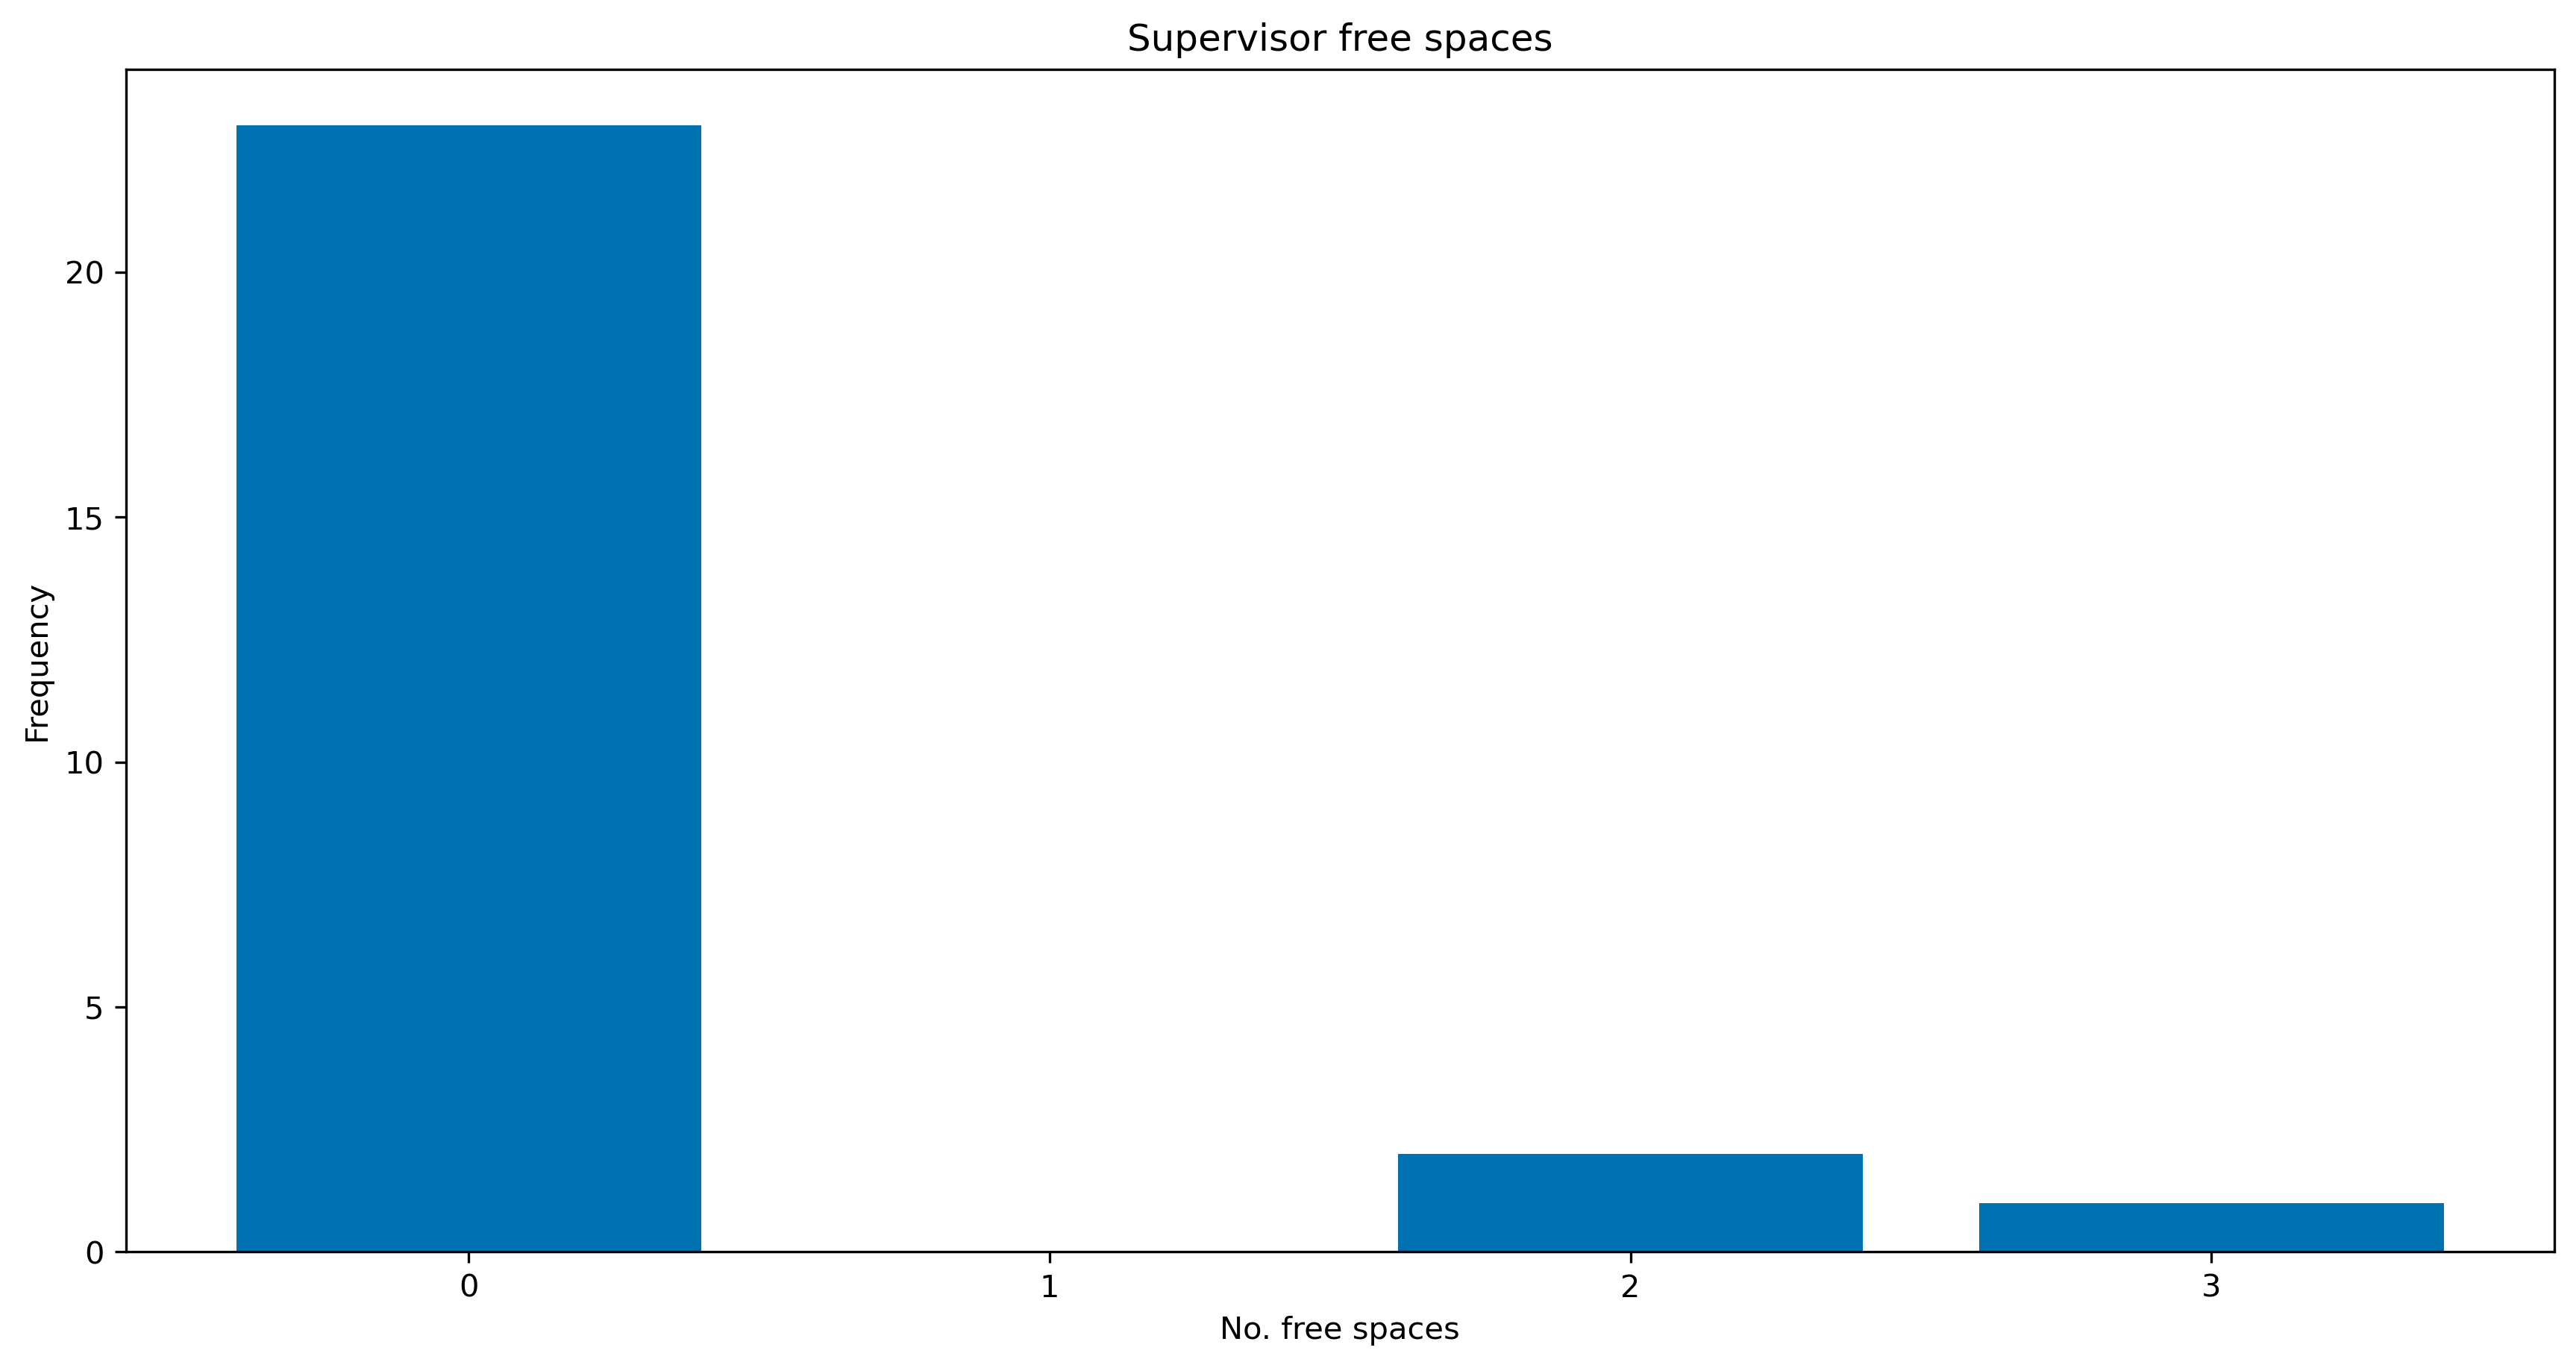

In [26]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

data = Counter(supervisor_free_spaces.values())
ax.bar(data.keys(), data.values())

ax.set_xlabel("No. free spaces")
ax.set_ylabel("Frequency")
ax.set_xticks(range(max(data.keys()) + 1))
ax.set_title("Supervisor free spaces")

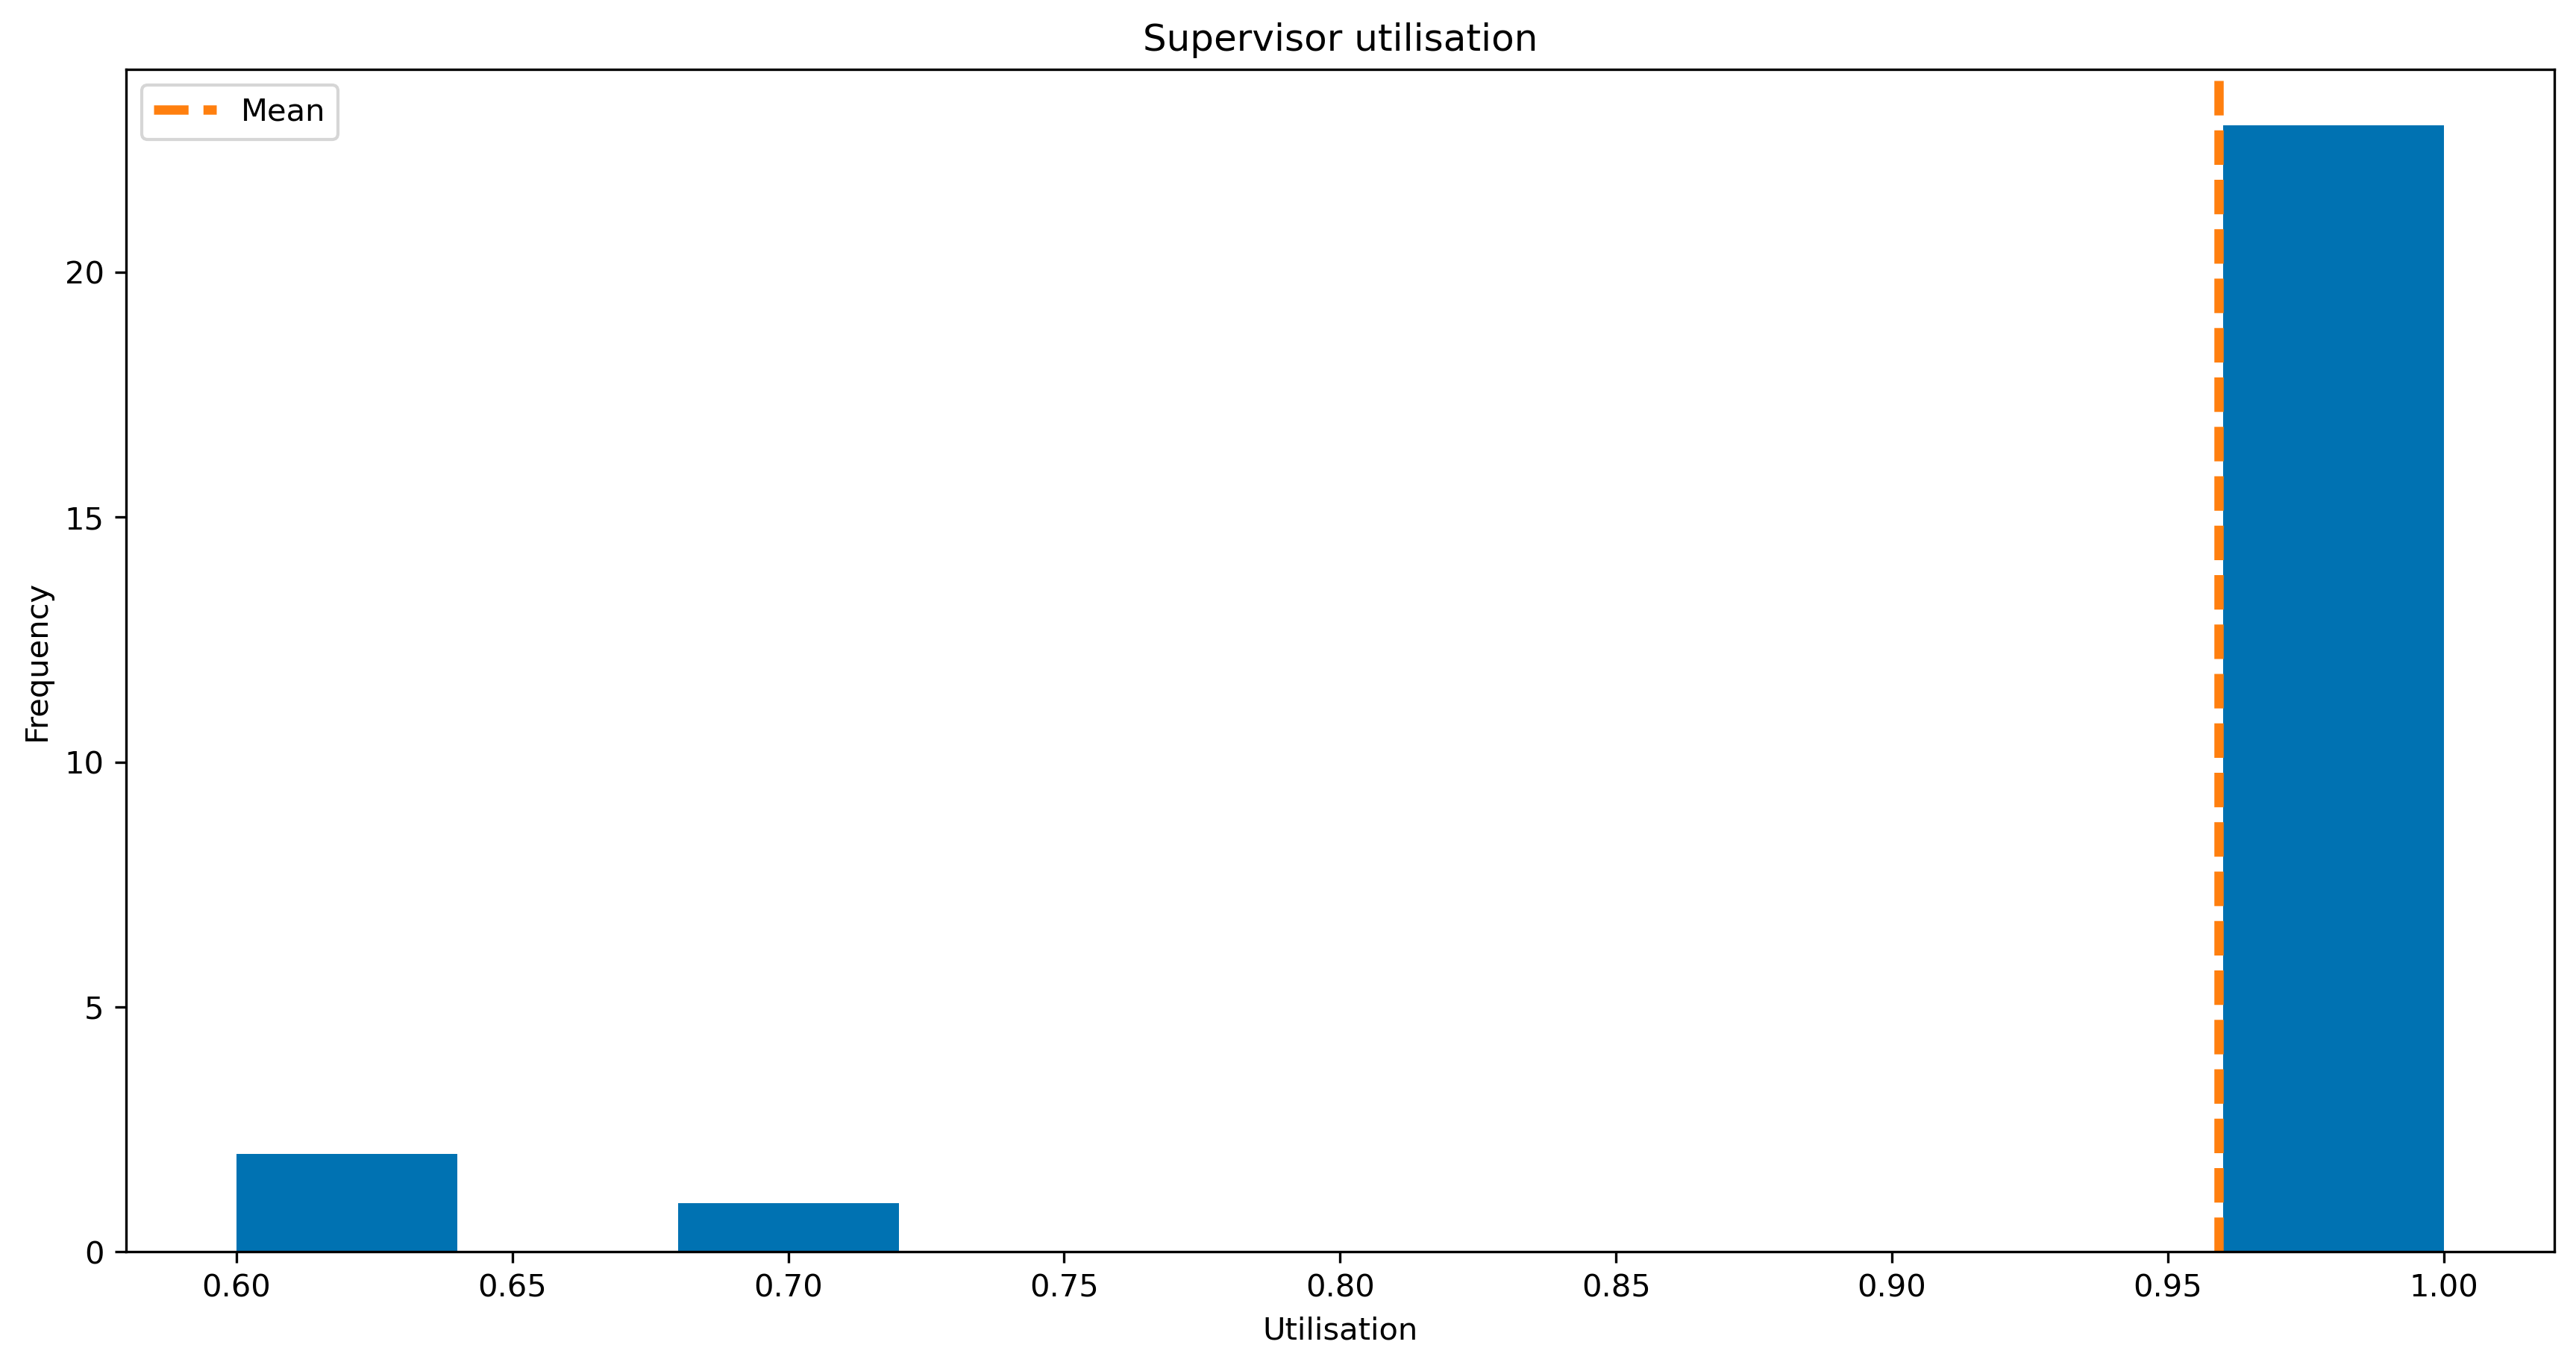

In [27]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = supervisor_utilisation.values()
ax.hist(values)

ylims = ax.get_ylim()
ax.vlines(np.mean(list(values)), *ylims, "tab:orange", "dashed", label="Mean", lw=3)
ax.set_ylim(*ylims)

ax.set_xlabel("Utilisation")
ax.set_ylabel("Frequency")
ax.set_title("Supervisor utilisation")
ax.legend()

So we can see that the supervisors are almost all working at capacity. This is a good thing so long as they accurately estimated their own workloads.

### Projects

We can do the same visualisation with the projects that were included in the game. This is a nice way to observe the quantity of excess projects offered to students.

In [28]:
project_free_spaces = {
    project.name: project.capacity - len(project.matching) for project in game.projects
}

project_utilisation = {
    project.name: len(project.matching) / project.capacity for project in game.projects
}

Text(0.5, 1.0, 'Project free spaces')

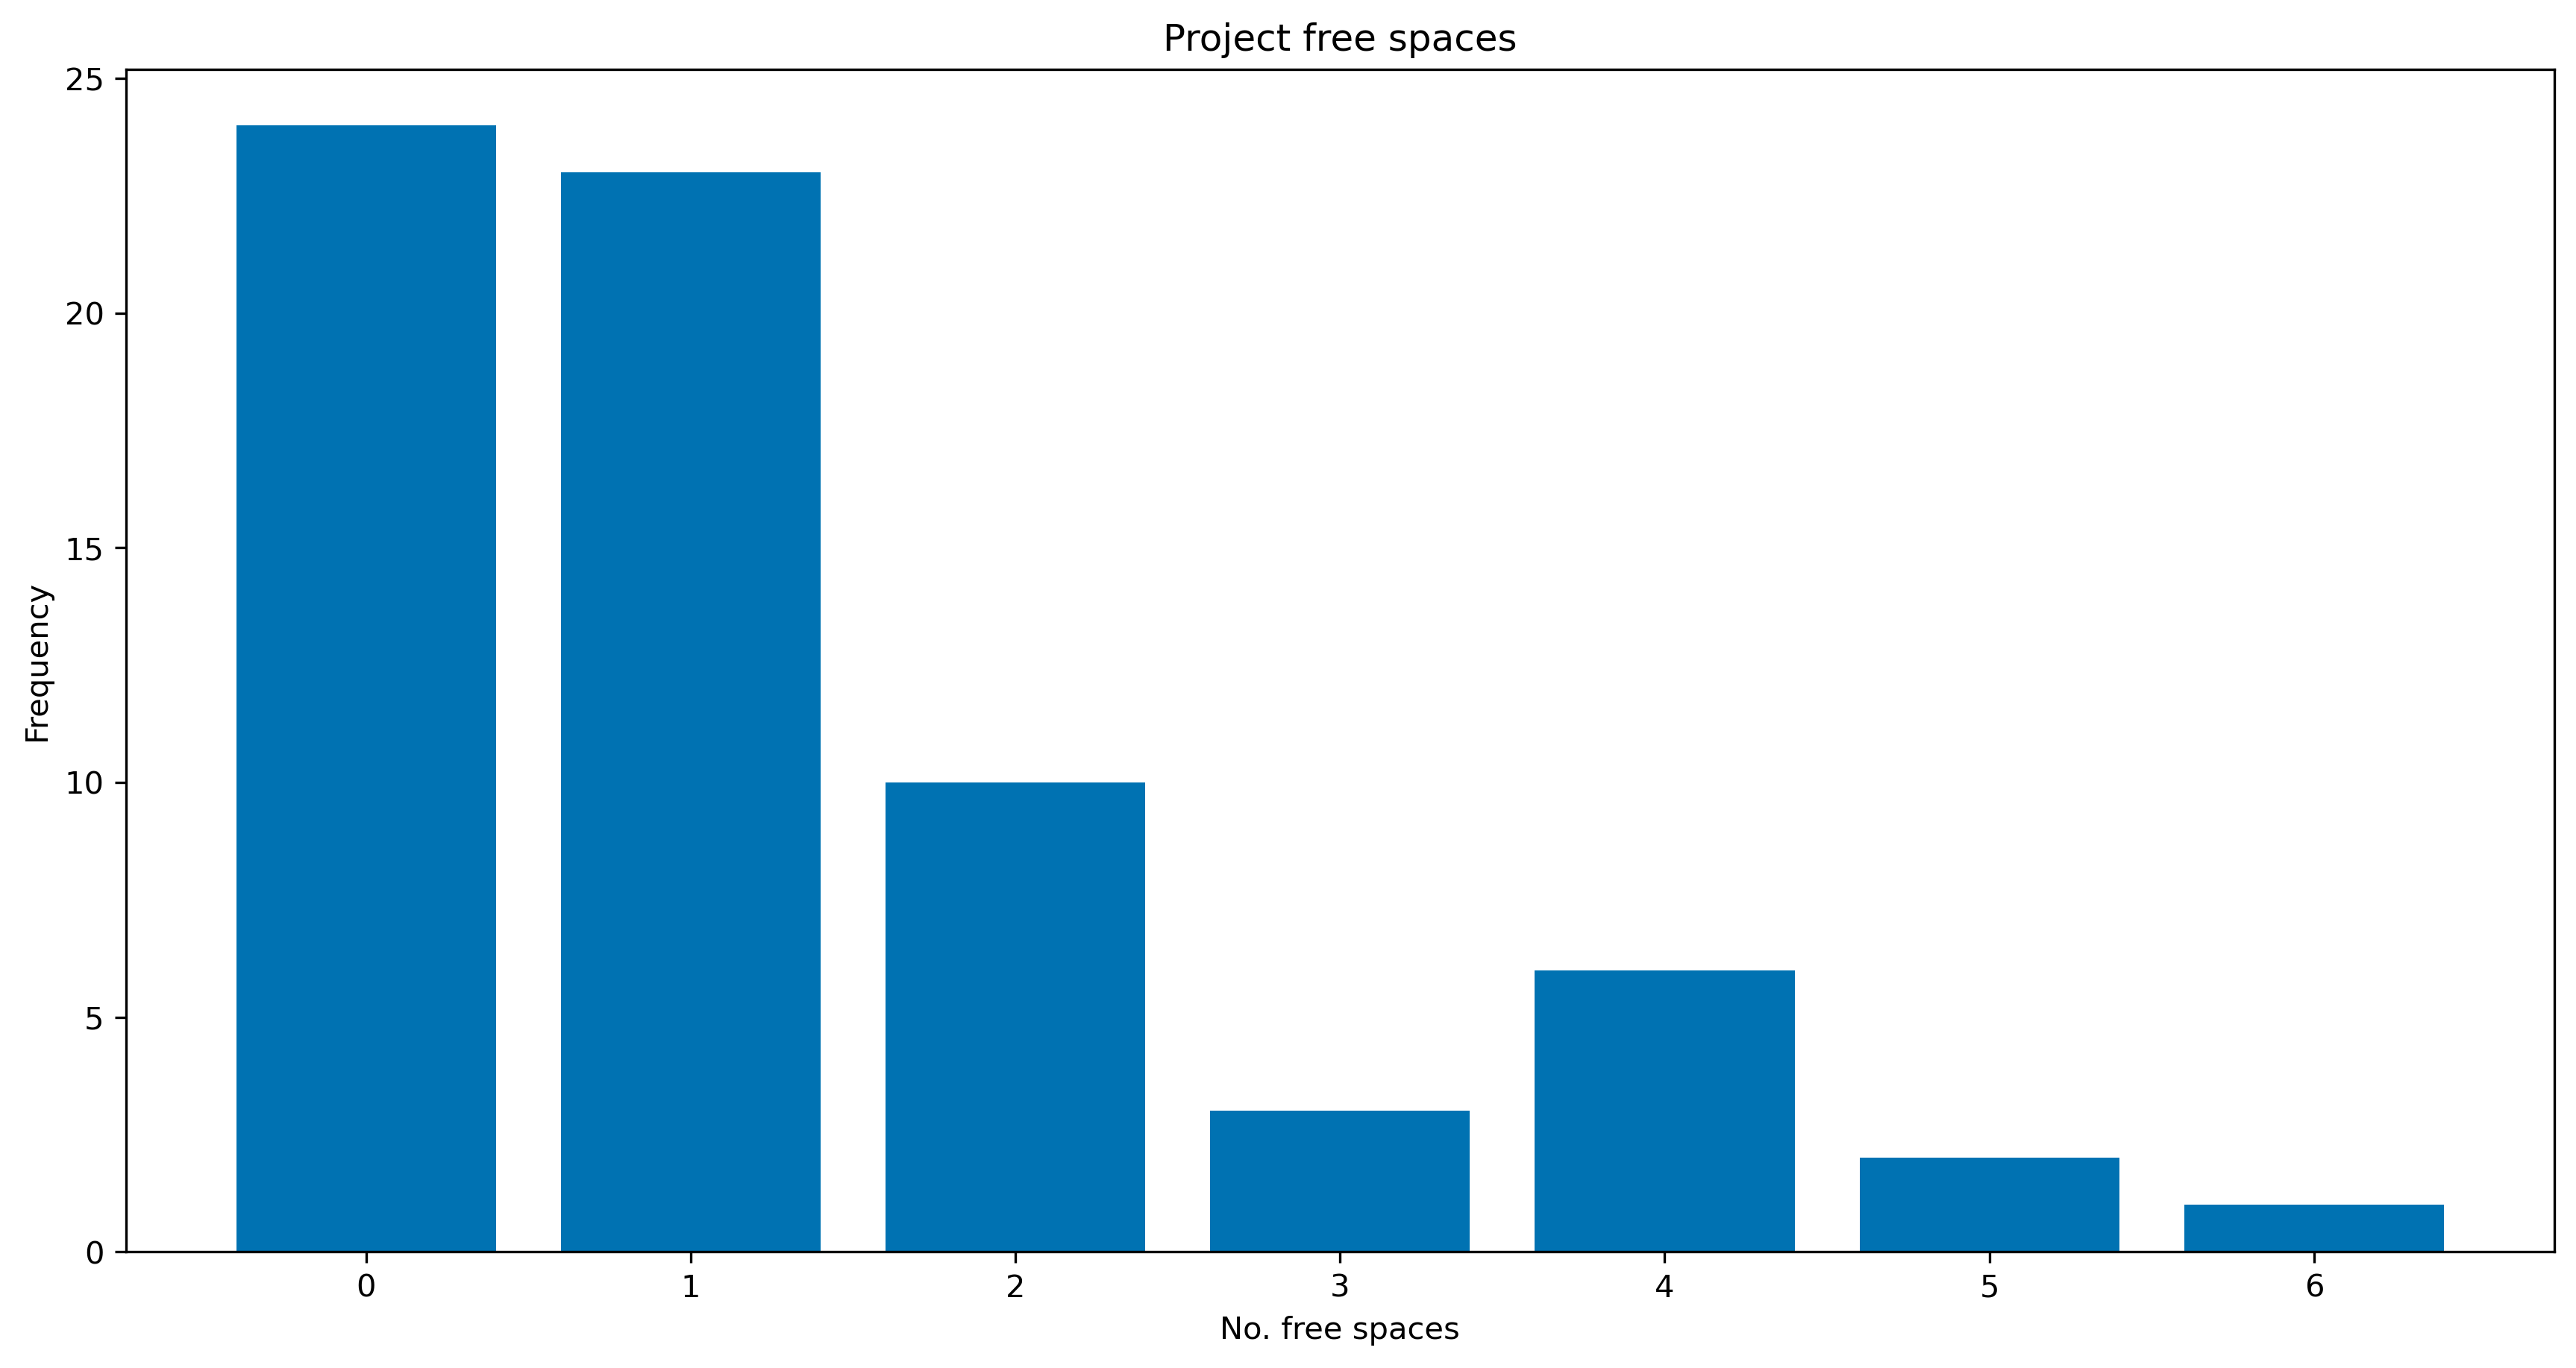

In [29]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

data = Counter(project_free_spaces.values())
ax.bar(data.keys(), data.values())

ax.set_xlabel("No. free spaces")
ax.set_ylabel("Frequency")
ax.set_xticks(range(max(data.keys()) + 1))
ax.set_title("Project free spaces")

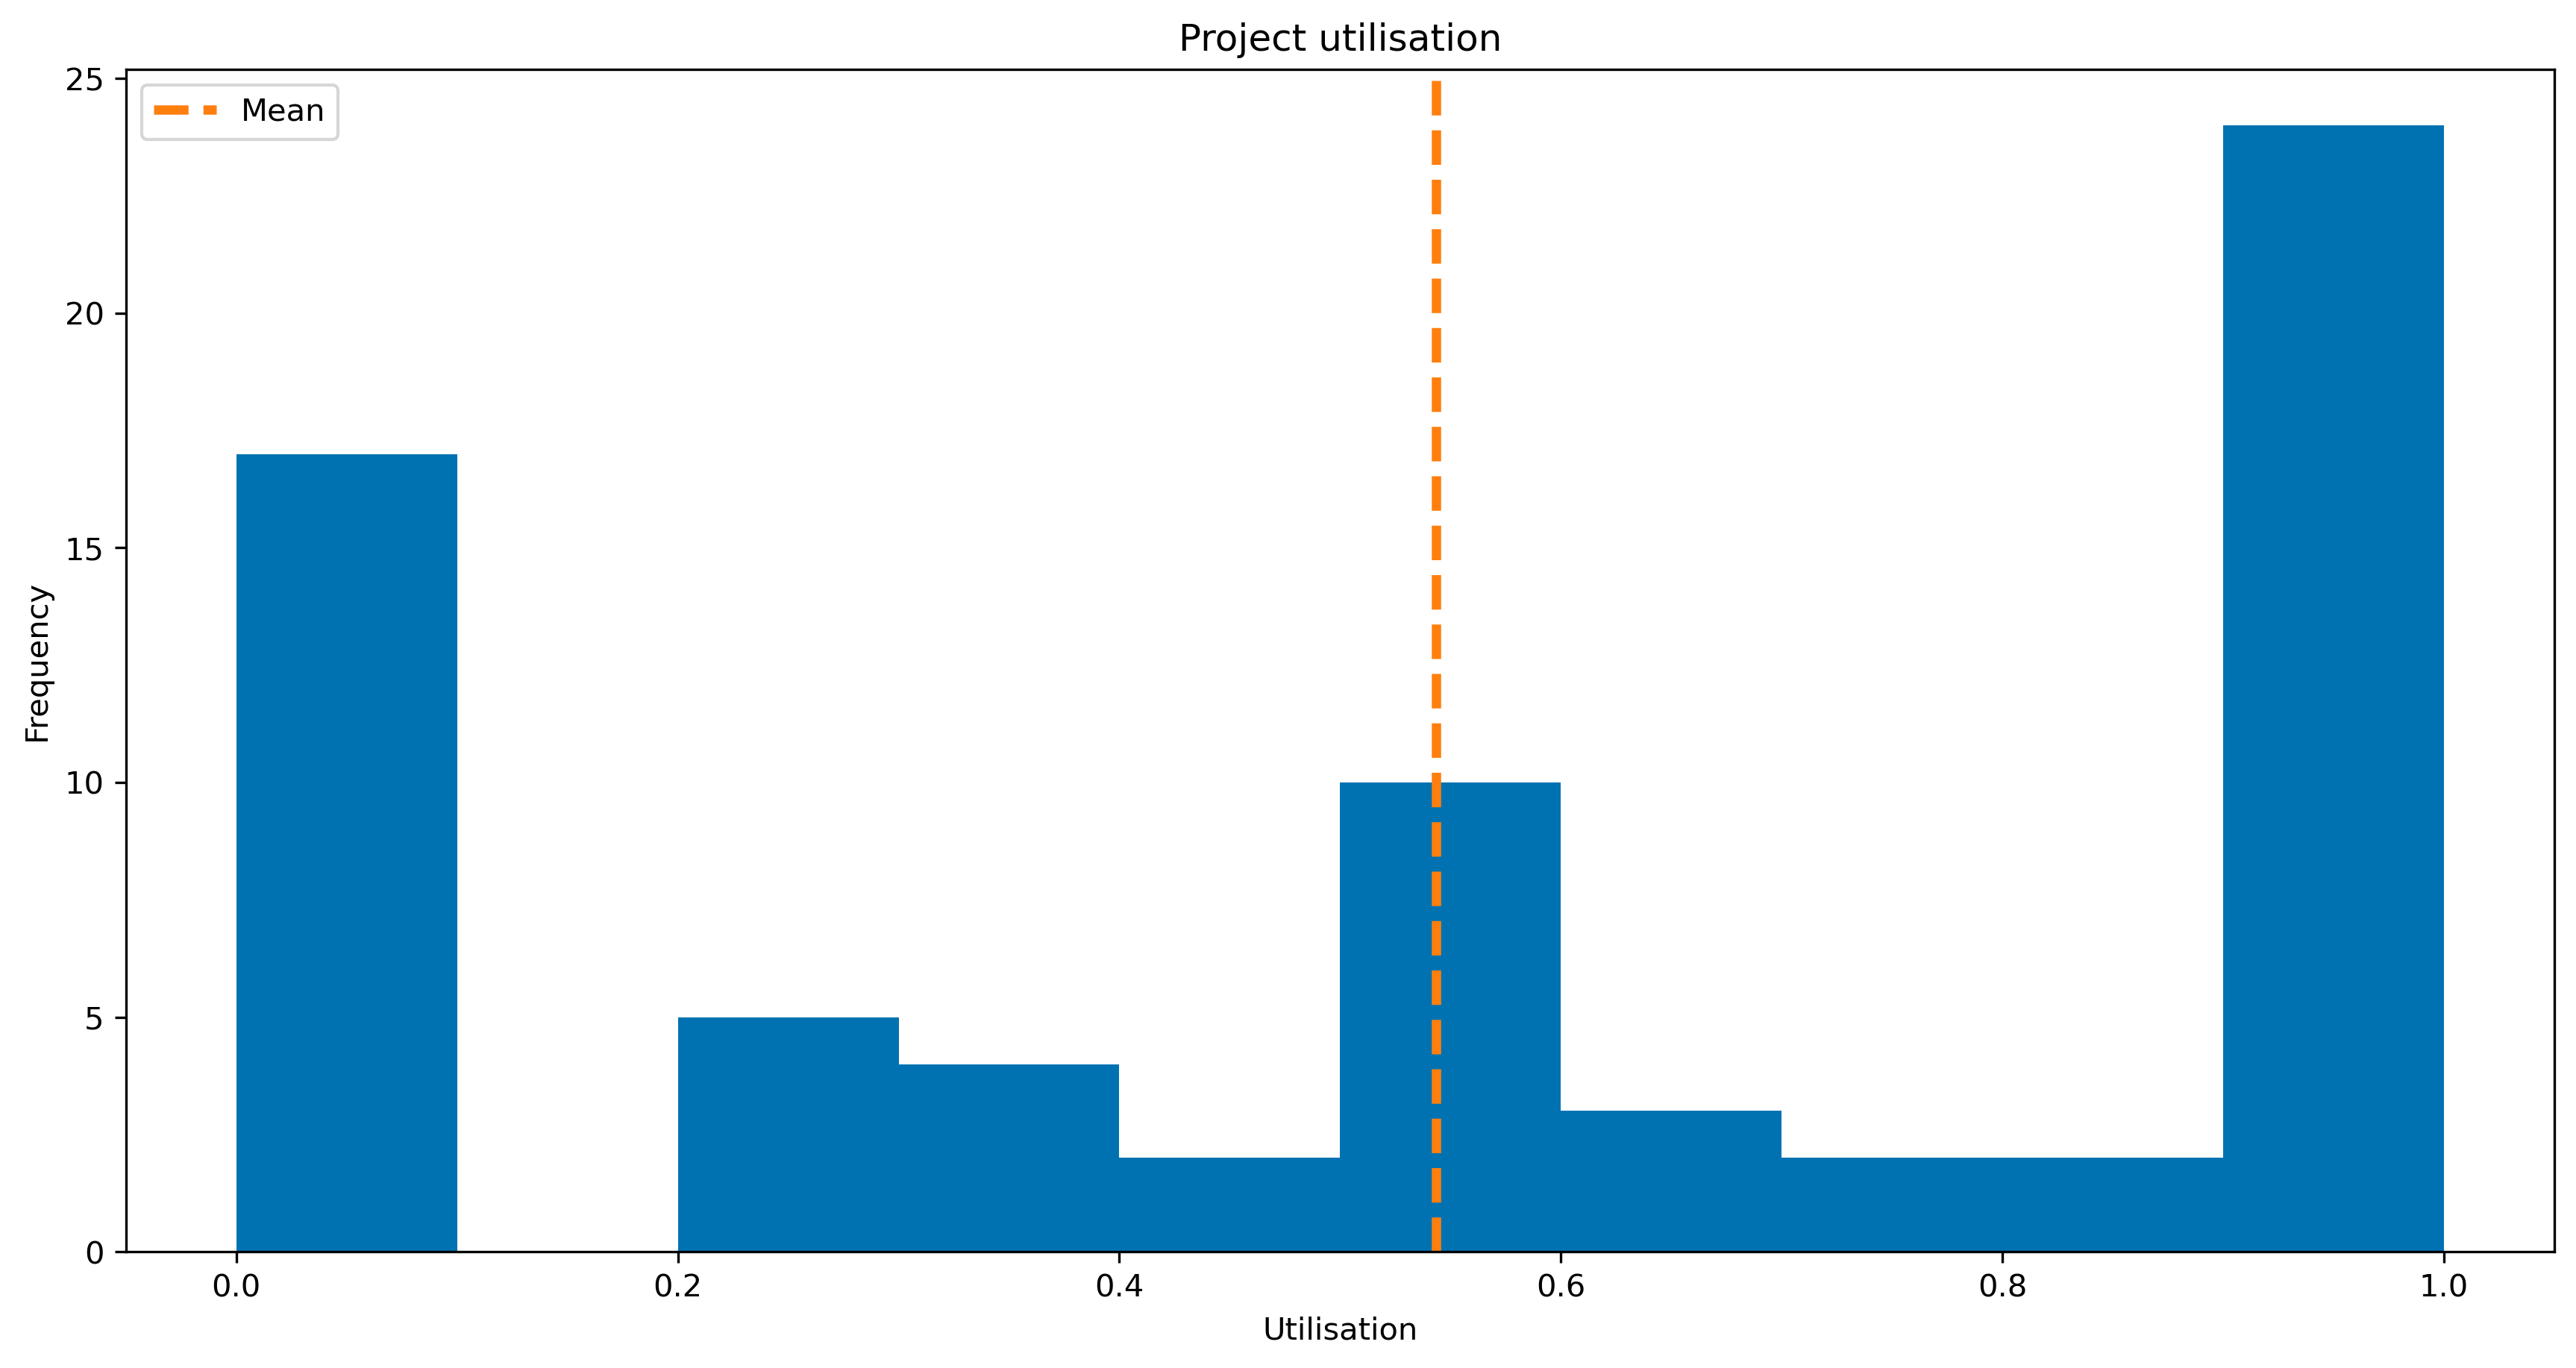

In [30]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = project_utilisation.values()
ax.hist(values)

ylims = ax.get_ylim()
ax.vlines(np.mean(list(values)), *ylims, "tab:orange", "dashed", label="Mean", lw=3)
ax.set_ylim(*ylims)

ax.set_xlabel("Utilisation")
ax.set_ylabel("Frequency")
ax.set_title("Project utilisation")
ax.legend()

The conclusion to draw from this is that the majority of projects seem to be split between two groups:

1. very popular (and busy) projects
2. very unpopular (and are excessive) projects

Results like this would help indicate where more projects should be offered in later years.

### Students

Arguably, the most valuable analysis is of the students and their matchings. To do this, we will need to "invert" the matching found by Matching.

In [31]:
inverted_matching = {}
student_preference_of_matching = []
for project, project_students in matching.items():
    for student in project_students:
        inverted_matching[student.name] = project.name
        student_preference_of_matching.append(student.pref_names.index(project.name))

This inverted matching can now be converted to a `pandas.DataFrame`. In this form, it is easy to link students between the matching data and the original as well as being able to extract those students who remain unmatched.

In [32]:
df_matching = pd.DataFrame(
    {
        "name": list(inverted_matching.keys()),
        "project_code": list(inverted_matching.values()),
        "preference": student_preference_of_matching,
    }
)

df_matching = df_matching.sort_values(by="name").reset_index(drop=True)

name_indexed_df_matching = df_matching.set_index("name")
name_indexed_raw_students = raw_students.set_index("name")

df_matching = pd.concat(
    (name_indexed_df_matching, name_indexed_raw_students["rank"]), axis=1
).reset_index()

In [33]:
unassigned_students = df_matching[df_matching["preference"].isnull()]

unassigned_students

,name,project_code,preference,rank
25,190025,NaN,NaN,89
29,190029,NaN,NaN,97
35,190035,NaN,NaN,99
40,190040,NaN,NaN,98
41,190041,NaN,NaN,72
82,190082,NaN,NaN,82
87,190087,NaN,NaN,65


In [34]:
assigned_students = df_matching[df_matching["preference"].notnull()]
assigned_students = assigned_students.astype({"preference": int})
assigned_students.head()

,name,project_code,preference,rank
0,190000,G2,0,3
1,190001,Q0,0,56
2,190002,U0,1,60
3,190003,C0,0,67
4,190004,I0,0,19


Now the data from the matching we've found is more manageable, we can try to understand how "good" it is.

Below is a bar chart showing the frequency of the students' preference over their match.

Text(0.5, 1.0, 'Student matching preferences')

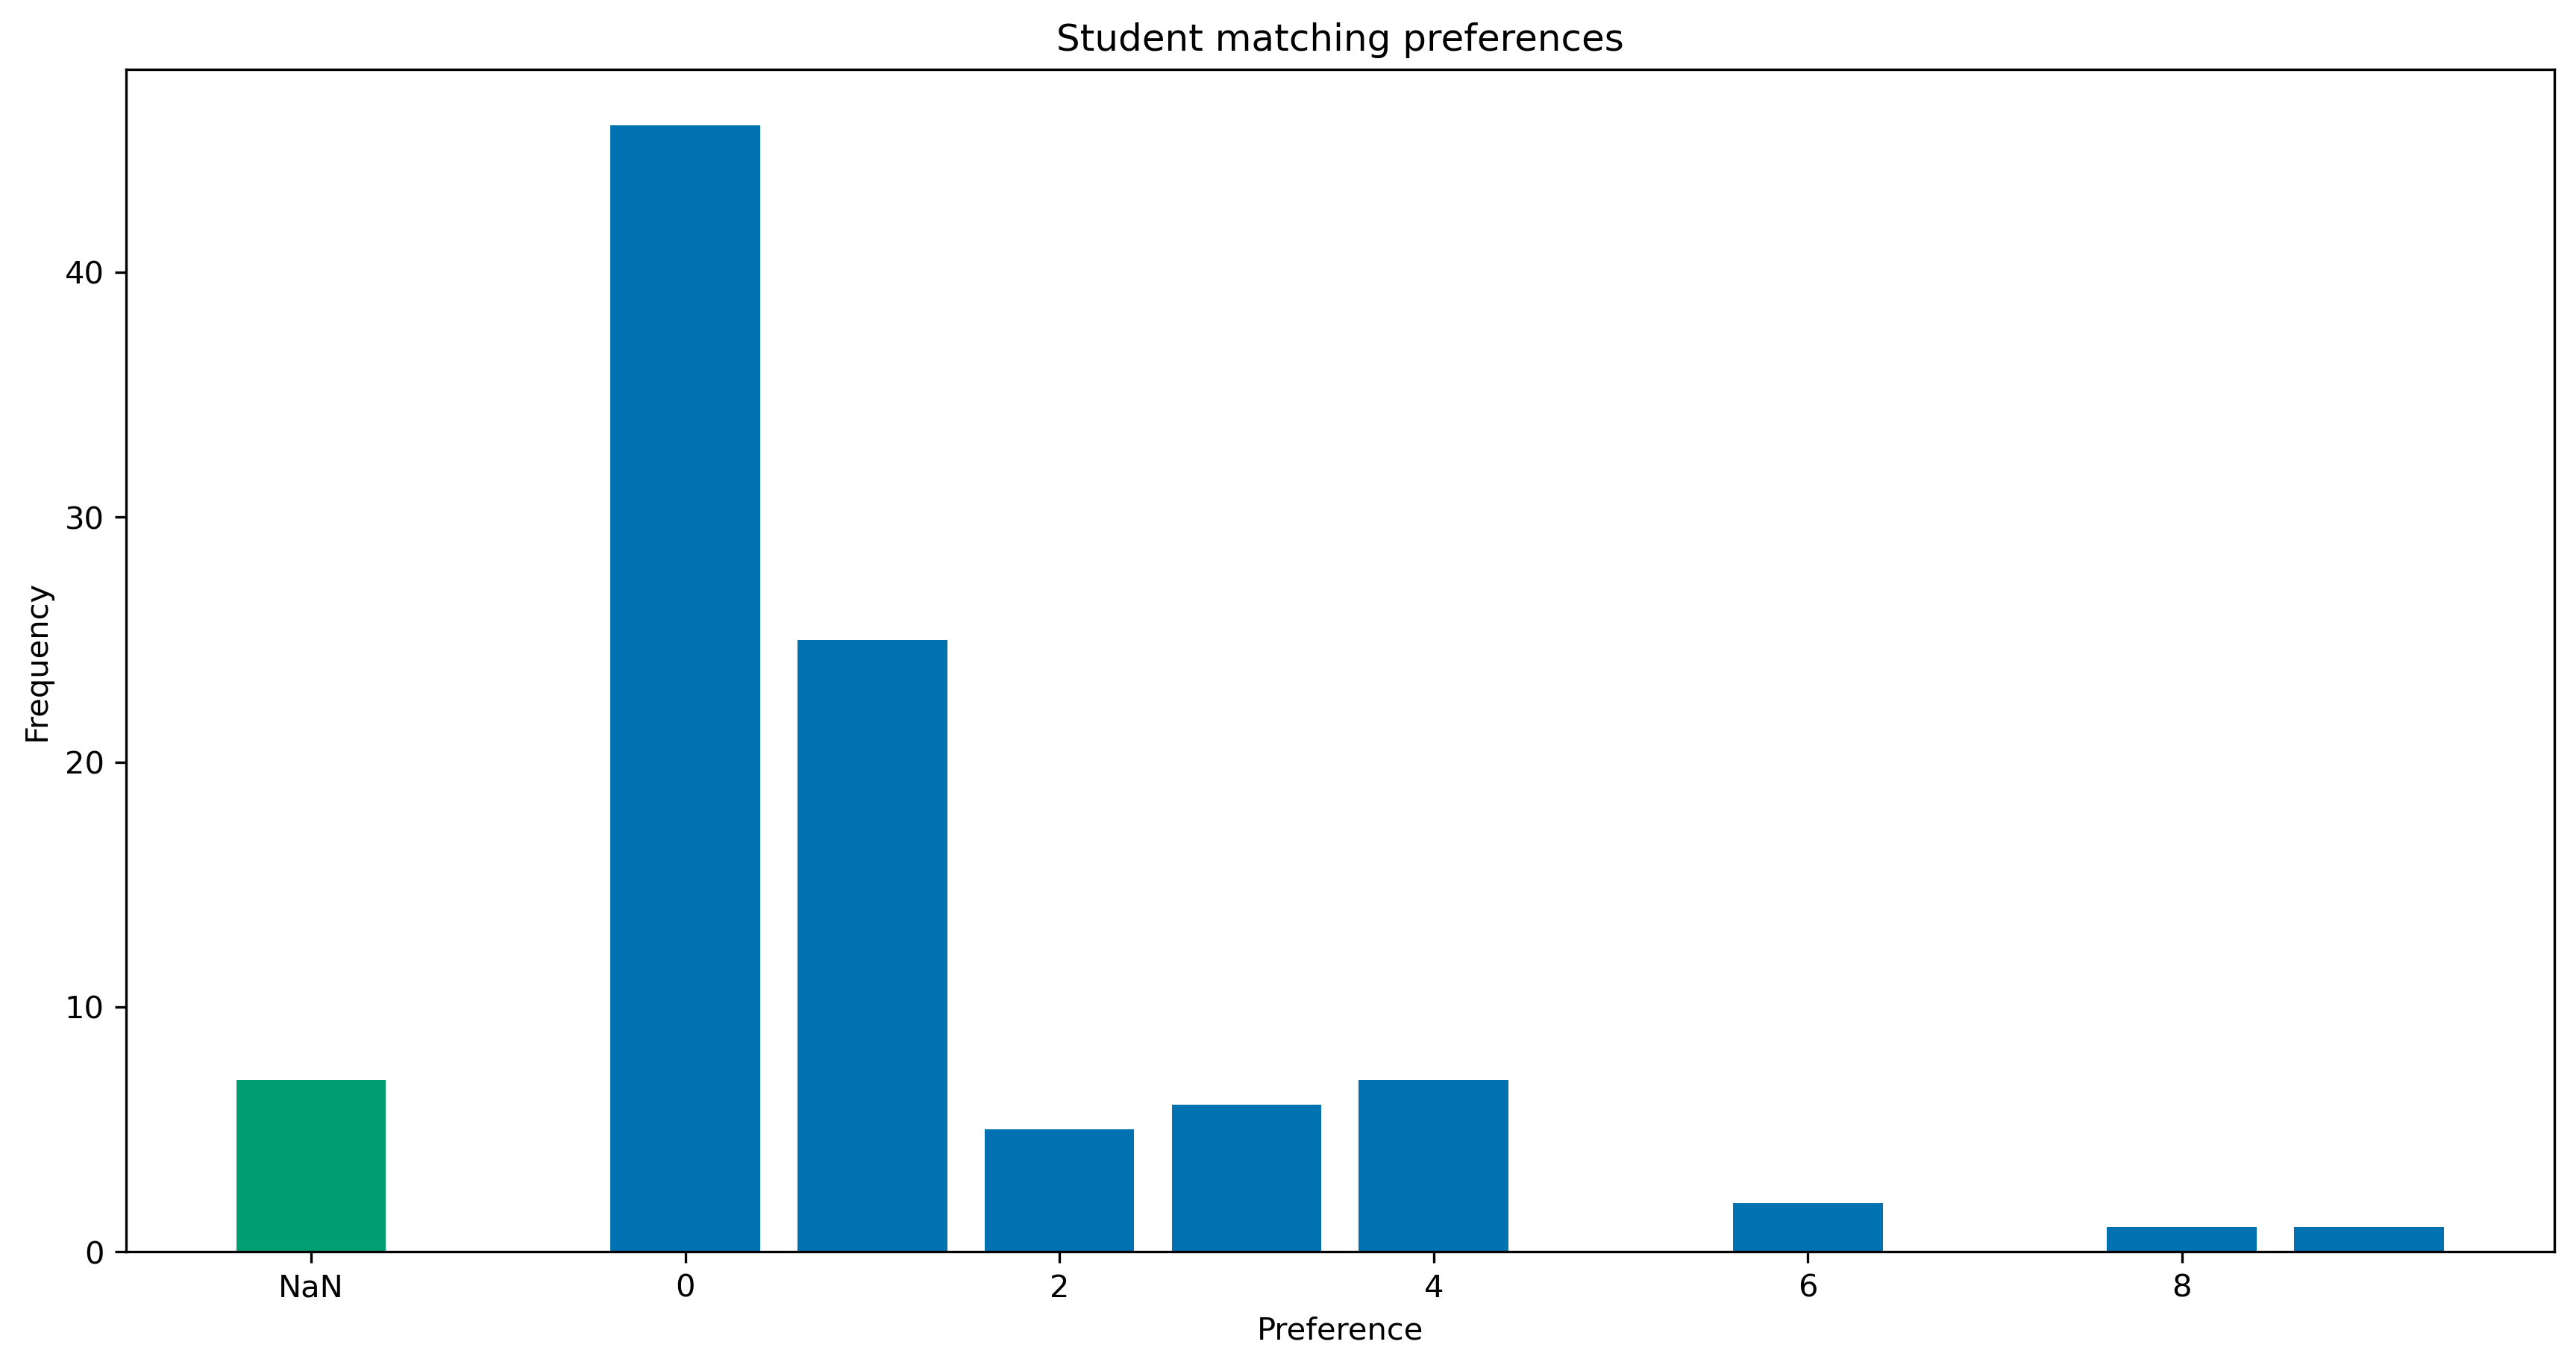

In [35]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = Counter(assigned_students["preference"])
ax.bar(values.keys(), values.values())
ax.bar(-2, len(unassigned_students))

ax.set_xticks([-2] + list(range(0, 10, 2)))
ax.set_xticklabels(["NaN"] + list(range(0, 10, 2)))
ax.set_xlabel("Preference")
ax.set_ylabel("Frequency")
ax.set_title("Student matching preferences")

We can see that the vast majority of students got their first or second choice which is great news.

Another thing we should consider is how appropriate the ranking is. Ideally, a student who ranks amongst the best in the cohort should get one of their first choices, and as the rank of the students go down, as should their preference of their match (on average, anyway).

Below is a scatter plot of student's rank and their preference of the project they were allocated.

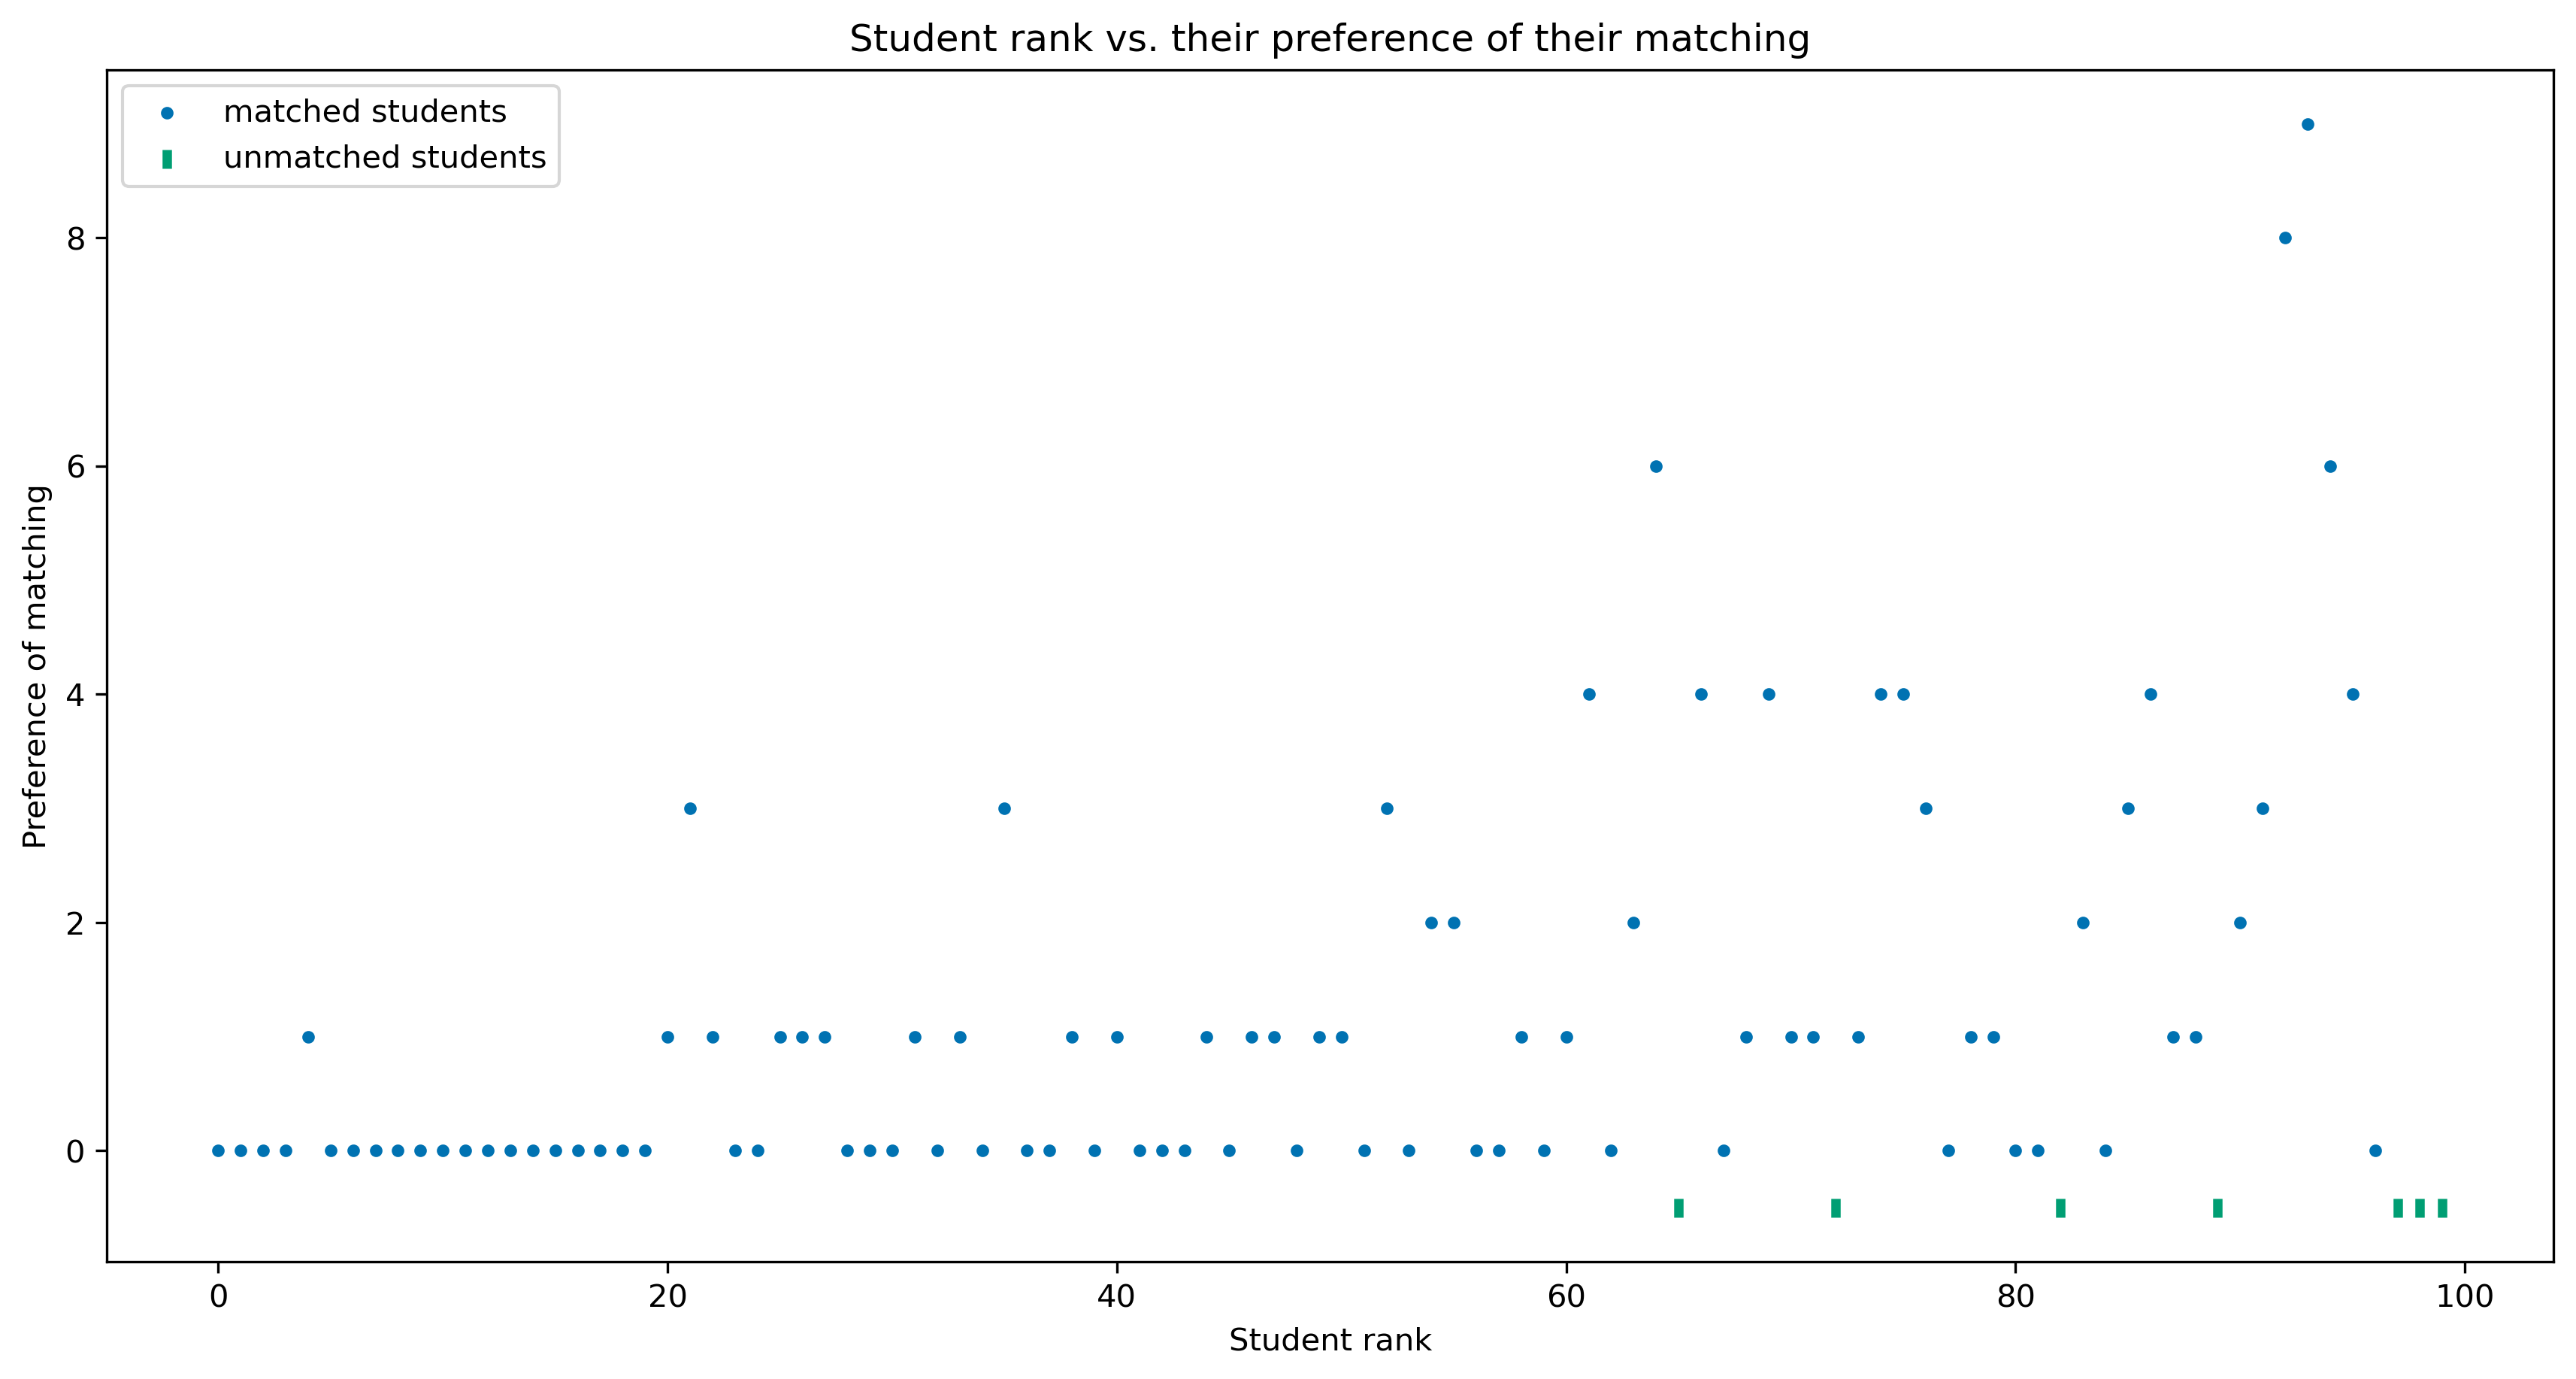

In [36]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

ax.scatter(
    assigned_students["rank"],
    assigned_students["preference"],
    marker=".",
    label="matched students",
)

ax.scatter(
    unassigned_students["rank"],
    [-0.5] * len(unassigned_students),
    marker="|",
    lw=3,
    label="unmatched students",
)

ax.set_xlabel("Student rank")
ax.set_ylabel("Preference of matching")
ax.set_title("Student rank vs. their preference of their matching")
ax.legend()

This is the kind of behaviour we want to see. There is a strong line along the bottom, as expected. Then, the cloud of less-preferable matches only grows towards the bottom of the ranking.

---

## Figuring out the remaining spaces

Alas, this is only a starting point. From here, adjustments can be made to the allocation -- although this is not recommended as this could break its [mathematical soundness](../../discussion/student_allocation/index.rst#The-algorithm). 

One avenue to take would be to offer the unassigned students a project with space left over. To figure out where there are spaces, we can use the `StudentAllocation` object and the data we cleaned earlier.

In [37]:
import warnings

warnings.filterwarnings("ignore")

In [38]:
project_with_space_names = [
    project.name
    for project in game.projects
    if len(project.matching) < project.capacity
] + list(unranked_projects)

supervisor_with_space_names = [
    supervisor.name
    for supervisor in game.supervisors
    if len(supervisor.matching) < supervisor.capacity
] + list(unranked_supervisors)

In [39]:
def get_number_of_matches(name, party, game):

    for player in vars(game)[party]:
        if player.name == name:
            return len(player.matching)

    return 0


def get_capacity(data, party, name):

    if party == "project":
        column = "code"
    else:
        column = "name"

    return data[data[column] == name]["capacity"].iloc[0]

In [40]:
projects_with_space = projects[
    (projects["code"].isin(project_with_space_names))
    & (projects["supervisor"].isin(supervisor_with_space_names))
]

In [41]:
projects_with_space["supervisor_capacity"] = projects_with_space["supervisor"].apply(
    lambda x: get_capacity(supervisors, "supervisor", x)
)

projects_with_space["project_matches"] = projects_with_space["code"].apply(
    lambda x: get_number_of_matches(x, "projects", game)
)

projects_with_space["supervisor_matches"] = projects_with_space["supervisor"].apply(
    lambda x: get_number_of_matches(x, "supervisors", game)
)

projects_with_space = projects_with_space[
    [
        "code",
        "capacity",
        "project_matches",
        "supervisor",
        "supervisor_capacity",
        "supervisor_matches",
    ]
]

In [42]:
projects_with_space = projects_with_space.set_index(["supervisor", "code"]).sort_index()

projects_with_space

capacity  project_matches  supervisor_capacity  \
supervisor code                                                   
C          C0           8                2                    8   
           C2           4                2                    8   
M          M0           8                2                    7   
Z          Z0           5                1                    5   

                 supervisor_matches  
supervisor code                      
C          C0                     5  
           C2                     5  
M          M0                     5  
Z          Z0                     3

So, with that we have completed this tutorial. We have taken raw data and created a strong allocation of projects to students. Not only that, but we have offered some analysis of this data to demonstrate its effectiveness.